In [90]:
import pypsa
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import yaml
import os

with open('../../pypsa-earth/config.SEA_base.yaml', 'r') as file:
    config = yaml.safe_load(file)

## Historical Comparison

In [109]:
def rename_techs_special(label):
    if "H2" in label:
        label = "hydrogen storage"
    elif label == "solar":
        label = "Solar"
    elif label == "offwind-ac":
        label = "Wind"
    elif label == "offwind-dc":
        label = "Wind"
    elif label == "onwind":
        label = "Wind"
    elif label == "ror":
        label = "Hydro"
    elif label == "hydro":
        label = "Hydro"
    elif label == "PHS":
        label = "Hydro"
    elif label == "coal":
        label = "Coal"
    elif label == "coal-CFB":
        label = "Coal"
    elif label == "coal-SC":
        label = "Coal"
    elif label == "coal-USC":
        label = "Coal"
    elif label == "coal-SubC":
        label = "Coal"
    elif label == "lignite":
        label = "Coal"
    elif label == "CCGT":
        label = "Gas"
    elif label == "biomass":
        label = "Bioenergy"
    elif "battery" in label:
        label = "battery storage"
    elif "oil" in label:
        label = "Other_Fossil"
    elif "geothermal" in label:
        label = "Other_RES"

    return label

def rename_country(label):
    if label == "Brunei Darussalam":
        label = "Brunei"
    elif label == "Lao":
        label = "Laos"
    elif label == "The Philippines":
        label = "Philippines"
    elif label == "Viet Nam":
        label = "Vietnam"

    return label

country_longname = {
    "MM": "Myanmar",
    "TH": "Thailand",
    "LA": "Laos",
    "SG": "Singapore",
    "KH": "Cambodia",
    "VN": "Vietnam",
    "BN": "Brunei",
    "PH": "Philippines",
    "Peninsular/MY": "Malaysia",
    "Sumatra/ID": "Indonesia",
    "Java-Bali/ID": "Indonesia",
    "Sarawak/MY":  "Malaysia",
    "Kalimantan/ID": "Indonesia",
    "Sabah/MY": "Malaysia",
    "Nusa-Tenggara/ID": "Indonesia",
    "Sulawesi/ID": "Indonesia",
    "Maluku/ID": "Indonesia",
    "Papua/ID": "Indonesia"
    }

preferred_order = pd.Index(
    [
        "transmission lines",
        "hydroelectricity",
        "hydro reservoir",
        "run of river",
        "pumped hydro storage",
        "onshore wind",
        "offshore wind ac",
        "offshore wind dc",
        "solar PV",
        "solar thermal",
        "OCGT",
        "hydrogen storage",
        "battery storage",
    ]
)

carrier_list = ["Coal","Gas","Other_Fossil","Bioenergy","Solar","Wind","Hydro","Other_RES"]

In [110]:
def extract_hist_data(parameter,carriers = carrier_list):

    df_all = pd.DataFrame()
    
    for carrier in carriers:
        df = pd.read_csv(f"../Tables/Historical Comparison/Historical_{parameter}_{carrier}.csv", sep= ";")
        df["year"] = df.index.get_level_values(1)
        df = df.query("year == '2020'")
        df = df.groupby(df.index.get_level_values(0)).sum()
        df = df.groupby(df.index.map(rename_country)).sum()
        df = df.rename(columns={"Unnamed: 1":carrier})
        df = df.loc[:,[carrier]]
    
        if df_all.empty:
            df_all = df
        else:
            df_all = pd.concat([df_all,df],axis=1)

    return df_all.apply(pd.to_numeric)

df_cap_hist = extract_hist_data("Capacity")
df_energy_hist = extract_hist_data("Generation")
df_co2_hist = extract_hist_data("Emission")

df_loads_hist = pd.read_csv(f"../Tables/Historical Comparison/Historical_Demand.csv", sep= ";",header=[1])
df_loads_hist = df_loads_hist.query("year == 2020").drop(columns={"year"})
df_loads_hist = df_loads_hist.set_index("country_or_region")
df_loads_hist = df_loads_hist.groupby(df_loads_hist.index.map(rename_country)).sum()

In [111]:
df_loads_hist

,demand_twh
country_or_region,
Brunei,5.74
Cambodia,12.80
Indonesia,293.37
Laos,10.59
Malaysia,172.46
Myanmar,17.54
Philippines,101.75
Singapore,53.07
Thailand,203.41


In [112]:
df_cap_hist

,Coal,Gas,Other_Fossil,Bioenergy,Solar,Wind,Hydro,Other_RES
Brunei,0.22,0.99,0.01,0.00,0.00,0.00,0.00,0.00
Cambodia,0.66,0.00,0.66,0.05,0.33,0.00,1.33,0.00
Indonesia,37.33,19.12,8.05,1.89,0.19,0.15,6.14,2.14
Laos,1.88,0.00,0.00,0.11,0.05,0.00,8.01,0.00
Malaysia,13.28,13.78,1.35,0.88,1.48,0.00,6.20,NaN
Myanmar,0.19,2.90,0.00,0.06,0.08,0.00,3.27,0.00
Philippines,10.75,3.32,4.24,0.51,1.06,0.44,3.04,1.93
Singapore,0.00,10.85,0.18,0.04,0.33,NaN,NaN,NaN
Thailand,6.14,32.35,0.00,4.07,2.98,1.51,3.11,NaN
Vietnam,20.29,8.15,0.00,0.39,16.66,0.52,20.82,NaN


In [113]:
df_co2_hist

,Coal,Gas,Other_Fossil,Bioenergy,Solar,Wind,Hydro,Other_RES
Brunei,1.06,4.05,0.03,0.00,0.00,0.00,0.00,0.00
Cambodia,3.54,0.00,0.26,0.02,0.01,0.00,0.10,0.00
Indonesia,155.49,36.10,4.46,2.67,0.01,0.01,0.58,0.59
Laos,10.42,0.00,0.00,0.01,0.00,0.00,0.68,0.00
Malaysia,74.77,33.92,0.56,0.27,0.10,0.00,0.65,NaN
Myanmar,2.12,6.63,0.13,0.06,0.00,0.00,0.21,0.00
Philippines,49.74,8.64,1.63,0.27,0.07,0.01,0.17,0.40
Singapore,0.48,24.29,0.14,0.26,0.01,NaN,NaN,NaN
Thailand,32.19,65.13,0.47,2.66,0.24,0.04,0.11,NaN
Vietnam,106.14,19.29,1.22,0.07,0.51,0.01,1.73,NaN


In [119]:
scenario_PyPSA = "SEA_EXIST_"
folder_name = "pypsa-earth"
dec_name = "BAU"

network_name = "elec_s_200_ec_lcopt_3H"
year = 2020
country= "all"

n = pypsa.Network(f"../../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_name}.nc")

countries = n.buses.country.unique()

#===============================================Capacity==================================================

cap_df_all = pd.DataFrame()

for country in countries:
    cap_df = pd.read_csv(f"../../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/capacity.csv", index_col=list(range(2)), header=[1, 2, 3])
    cap_df["component"] = cap_df.index.get_level_values(0)
    cap_df = cap_df[cap_df.component == "generators"]
    cap_df = cap_df.drop(columns=["component"])
    cap_df = cap_df.groupby(cap_df.index.get_level_values(1)).sum()
    cap_df = cap_df.groupby(cap_df.index.map(rename_techs_special)).sum()
    carrier_exist = [value for value in cap_df.index if value in carrier_list]
    cap_df = cap_df.loc[carrier_exist,:]
    cap_df.columns = [country]

    if cap_df_all.empty:
        cap_df_all = cap_df
    else:
        cap_df_all = pd.concat([cap_df_all,cap_df],axis=1)

cap_df_all = cap_df_all.T.reset_index().rename(columns={"index":"country"})
cap_df_all["country"] =  [country_longname[c] for c in cap_df_all.country]
cap_df_all = cap_df_all.groupby("country").sum() /1e3

#===============================================Generation==================================================

energy_df_all = pd.DataFrame()

for country in countries:
    energy_df = pd.read_csv(f"../../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/energy.csv", index_col=list(range(2)), header=[1, 2, 3])
    energy_df = energy_df.groupby(energy_df.index.get_level_values(1)).sum()
    energy_df = energy_df.groupby(energy_df.index.map(rename_techs_special)).sum()
    carrier_exist = [value for value in energy_df.index if value in carrier_list]
    energy_df = energy_df.loc[carrier_exist,:]
    energy_df.columns = [country]

    if energy_df_all.empty:
        energy_df_all = energy_df
    else:
        energy_df_all = pd.concat([energy_df_all,energy_df],axis=1)

energy_df_all = energy_df_all.T.reset_index().rename(columns={"index":"country"})
energy_df_all["country"] =  [country_longname[c] for c in energy_df_all.country]
energy_df_all = energy_df_all.groupby("country").sum() /1e6

#===============================================LOADS==================================================

loads_df_all = pd.DataFrame()

for country in countries:
    loads_df = pd.read_csv(f"../../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/energy.csv", index_col=list(range(2)), header=[1, 2, 3])
    loads_df = -loads_df.groupby(loads_df.index.get_level_values(0)).sum()
    loads_df.columns = [country]
    loads_df = loads_df.loc["loads",:].T

    if loads_df_all.empty:
        loads_df_all = loads_df
    else:
        loads_df_all = pd.concat([loads_df_all,loads_df],axis=0)

loads_df_all = loads_df_all.T.reset_index().rename(columns={"index":"country"})
loads_df_all["country"] =  [country_longname[c] for c in loads_df_all.country]
loads_df_all = loads_df_all.groupby("country").sum() /1e6


C:\Users\kunde\anaconda3\envs\esm-2024\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
C:\Users\kunde\anaconda3\envs\esm-2024\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
C:\Users\kunde\anaconda3\envs\esm-2024\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float

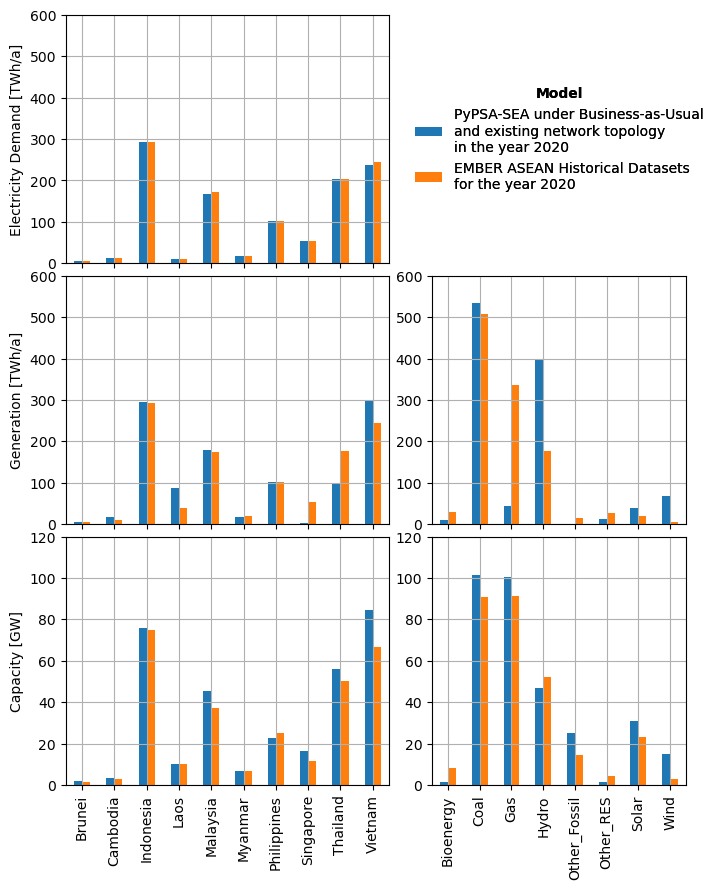

In [122]:
fig, ax = plt.subplots(3, 2, figsize=(8,10), gridspec_kw={'width_ratios': [2.8,2.2]})
plt.subplots_adjust(wspace=0.15, hspace=0.05)

df_plot = pd.DataFrame({"PyPSA-SEA":cap_df_all.T.sum(),"Historical Data":df_cap_hist.T.sum()})
df_plot.plot.bar(ax=ax[2,0], legend=False, ylim=([0,120]))

ax[2,0].set_ylabel("Capacity [GW]")

df_plot = pd.DataFrame({"PyPSA-SEA":cap_df_all.sum(),"Historical Data":df_cap_hist.sum()})
df_plot.plot.bar(ax=ax[2,1], legend=False, ylim=([0,120]))

df_plot = pd.DataFrame({"PyPSA-SEA":energy_df_all.T.sum(),"Historical Data":df_energy_hist.T.sum()})
df_plot.plot.bar(ax=ax[1,0], legend=False, ylim=([0,600]))

ax[1,0].set_ylabel("Generation [TWh/a]")

df_plot = pd.DataFrame({"PyPSA-SEA":energy_df_all.sum(),"Historical Data":df_energy_hist.sum()})
df_plot.plot.bar(ax=ax[1,1], legend=False, ylim=([0,600]))

df_plot = pd.DataFrame({"PyPSA-SEA":loads_df_all.loads,"Historical Data":df_loads_hist.demand_twh})
df_plot.plot.bar(ax=ax[0,0], legend=False, ylim=([0,600]))

ax[0,0].set_ylabel("Electricity Demand [TWh/a]")

legend_label = ["PyPSA-SEA under Business-as-Usual\nand existing network topology\nin the year 2020","EMBER ASEAN Historical Datasets\nfor the year 2020"]

pypsa.plot.add_legend_patches(ax=ax[0, 1], colors = ["tab:blue","tab:orange"], labels = legend_label,
                             legend_kw = {'loc':"center",'bbox_to_anchor':(0.5, 0.5), 'frameon':False, 'ncol':1, 'title':"Model", 
                                          'title_fontproperties':{'weight':'bold'}})
ax[0, 1].axis('off')

for a in [0,1,2]:
    for b in [0,1]:
        ax[a,b].grid(axis="y")
        ax[a,b].grid(axis="x")
        #ax.grid(True)
        if a != 2:
            ax[a,b].set_xticklabels([])

plt.savefig(f'../Figures/Compare_baseyear_2020.svg',bbox_inches='tight')

In [123]:
energy_df_all.sum()

Gas              43.008190
Solar            39.479262
Wind             69.033702
Bioenergy         9.584990
Coal            534.804364
Hydro           395.734805
Other_Fossil      0.259305
Other_RES        11.338240
dtype: float64

In [124]:
df_energy_hist.sum()

Coal            506.98
Gas             335.29
Other_Fossil     13.52
Bioenergy        29.04
Solar            20.12
Wind              5.70
Hydro           177.61
Other_RES        26.33
dtype: float64